In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Looking at general info of the dataframe missing values and the dtypes of each column in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [34]:
# Function for checking percentage of missing values in every column in the dataframe and putting values in a dictionary then a dataframe
# Also creates a new column for the datatype of the columns.
def missing_percentage(df):

    # Dictionary for putting percentage of missing values
    missing_values_percentage = {}
    
    # Loop for calculating percentage of missing values and putting values in dictionary
    for column in df.columns:
        missing_values_percentage[column] = df[column].isnull().sum() / len(df[column]) * 100

    # Creating dataframe of the dictionary
    missing_df = pd.Series(missing_values_percentage)
    missing_df = pd.DataFrame(missing_df, columns=['Percentage Missing'])


    # Creating a new column for the dtype of the column with missing values.
    missing_df['dtype'] = [df[column].dtypes for column in missing_df.index]

    return missing_df





In [40]:
# Copy of data to test our new function.
X_test = df.copy()

# Testing
missing_percentage(X_test)

,Percentage Missing,dtype
id,0.000000,int64
date,0.000000,object
price,0.000000,float64
bedrooms,0.000000,int64
bathrooms,0.000000,float64
sqft_living,0.000000,int64
sqft_lot,0.000000,int64
floors,0.000000,float64
waterfront,11.001528,object
view,0.291707,object


In [36]:
# Function for checking for wrong datatypes in each column in the dataframe.

def wrong_data(df):
    # Dictionary for mapping
    value_types = {
        'int64': int,
        'object': str,
        'float64': float
    }
    # Dictionary for mapping columns with wrong datatypes
    wrong_data_types = {}

    # Loop which checks for every column in the dataframe if it has wrong datatypes.
    for column in df.columns:
        wrong_data_types[column] = [x for x in df[column] if type(x) != value_types[str(df[column].dtypes)]]

    # Final results
    return wrong_data_types



In [78]:
# Testing our function on a copy of the data
wrong_data(X_test)['yr_renovated']



[]

In [45]:
df['waterfront'].unique()

array([nan, 'NO', 'YES'], dtype=object)

Text(0.5, 1.0, 'Histogram of SalePrices before Standardization')

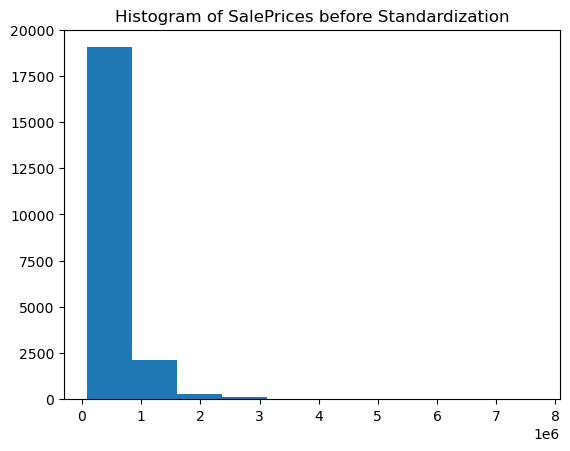

In [80]:
# Histogram of price before removing outliers
plt.hist(df['price'])
plt.title('Histogram of SalePrices before Standardization')

In [56]:
numeric_variables = X_test.select_dtypes(include=np.number).columns.to_list()

numeric_variables

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'sqft_above',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [63]:
# Function for checking outliers in a dataframe removing them and creating a new dataframe without outliers
def outliers(df):

    # Dictionary for placing no. of outliers and the column name.
    outliers_dict = {}
    standardized_dict = {}

    # For loop for checking outliers in every column in the dataframe.
    for column in df.columns:
        # Lower quantile
        Q1 = df[column].quantile(0.25)

        # Upper Quantile
        Q3 = df[column].quantile(0.75)

        # Finding IQR
        IQR = Q3 - Q1

        # Defining lower and upper bound
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        # Finding outliers
        outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_dict[column] = 'The number of outliers is', len(outliers)

        # Data without outliers
        standardized_numvotes = df[column][(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
        # Putting standardized values in a dict
        standardized_dict[column] = standardized_numvotes

    
    standardized_df = pd.DataFrame(standardized_dict)  

    # Results
    return standardized_df

    

        



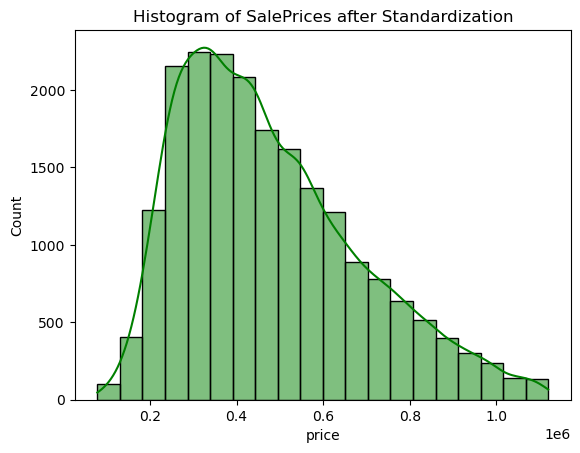

In [87]:
new_df = outliers(X_test[numeric_variables])

# Histogram of price after removing outliers.
sns.histplot(new_df['price'], kde=True, color='green', bins=20)
plt.title('Histogram of SalePrices after Standardization');